In [251]:
import pandas as pd
import numpy as np
import json
import dask.bag as db
import dask.dataframe as dd
import tensorflow as tf
#import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Table of Contents
[Step 0](#part0) The statement of the problem <br>
[Step 1](#part1) From bres select impressions with sflr == 15 <br>
[Step 2](#part2) Extract relevant fields from the raw bres  with sflr == 15: resulting file 'processed_bres_15_date.pkl' <br>
[Step 3](#part3) Extract relevant fields form om file. Mark those impressions in bres that are in om with Y or N depending on whether the bid was successful or not <br>
[Step 4](#part4) Plot the data, zero in on the floor price bids  <br>
[Step 5](#part5) Clean the resulting dataframe
    a. convert time to hourly slots
    b. cleanup the text /categories in the columns <br>
[Step 6](#part6) Split the dataframe into two:  sbpr = 15 and sbpr != 15 <br>
[Step 7](#part7). Use sbpr = 15 for classification. <br>
[Step 8](#part8) Based on the model in Step 6 predict which impressions should not be in sbpr != 15 dataframe. Eliminate those from the dataframe <br>
[Step 9](#part9) Plot the learned probability.

Step 0: The statement of the problem and summary of the results. <br>
<a id="part0"></a>


The problem comes from the world of real-time bidding in advertising. To simplify for the purposes of this short POC, a platform submits bids for ads (impressions), following some strategy. Some of these bids get accepted and the question is how to optimize the strategy. 
More specifically, each impression is submitted with a floor price 'sflr' and the platform places bids at prices 'sbpr' $>=$ 'sflr'. In the ideal world one expects the probability of the bid being accepted to be a monotonically increasing function the bid price 'sbpr'. 
However, as the plot below shows this is totally not the case. In this example I'm displaying the probability for a single 'sflr'$=$15.0 for one day.

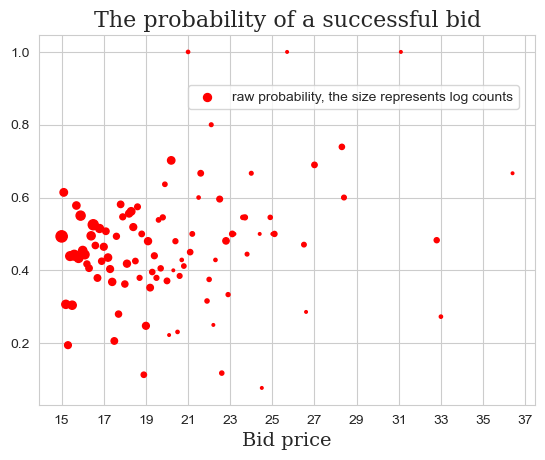

In [229]:
fig_prob

Several things jump out from the figure:
1. there are lots of bids at the floor price.
2. there are bid prices with 100% probability of winning.
to be precise 

Step 1: Extraction of data from the submitted bids 'bres' and accepted bids 'om' files.
<a id="part1"></a>

Start with the submitted bids, will take the data for one, and only one floor price 'sflr' $=$ 15

In [253]:
df_0409 = dd.read_json('bres_0409.json', blocksize="128 MiB", lines=True) # load the json file

In [254]:
df_0409.head() # take a look

,level,demand_partner,opn,dbpr,sbpr,dflr,sflr,publisher_id,kgrp,bidrequest,bidresponse,time,message
0,info,freewheel,1.1,2.250924,2.125462,2.1,2.0,18000792,c,"{""id"":""b97c3bdb-cd9d-439e-8562-4ccd52245965"",""...","{'id': 'b97c3bdb-cd9d-439e-8562-4ccd52245965',...",2024-04-09T00:00:00Z,response
1,info,freewheel,1.4,2.325414,2.000000,2.1,2.0,18000792,t,"{""id"":""1cbcb65d-1f4c-4f03-bdc6-8f92be484672"",""...","{'id': '1cbcb65d-1f4c-4f03-bdc6-8f92be484672',...",2024-04-09T00:00:00Z,response
2,info,wurl,1.4,12.000000,10.000000,10.5,10.0,109759,c,"{""id"":""78f06a03-ece8-4113-bdc5-e03d488bb32f"",""...","{'id': '78f06a03-ece8-4113-bdc5-e03d488bb32f',...",2024-04-09T00:00:00Z,response
3,info,bidswitch,3.4,17.112000,16.000000,18.4,16.0,94372221,t,"{""id"":""coa8a05itjdcn86dc5g0"",""imp"":[{""id"":""520...","{'id': 'coa8a05itjdcn86dc5g0', 'seatbid': [{'b...",2024-04-09T00:00:00Z,response
4,info,wurl,2.4,12.000000,10.000000,11.0,10.0,109759,t,"{""id"":""b2106c3b-9688-47d9-9cdc-7c57a4446e54"",""...","{'id': 'b2106c3b-9688-47d9-9cdc-7c57a4446e54',...",2024-04-09T00:00:00Z,response


In [255]:
df1_0409 = df_0409.drop(['level', 'demand_partner', 'opn', 'dbpr', 'dflr', 'kgrp', 'message','bidresponse'], axis=1)
df_raw0409_15 = df1_0409[df1_0409['sflr']== 15.0].drop(['sflr'], axis=1).reset_index(drop=True) # drop redundant fields, keep floor price $15.0 only

In [256]:
df_raw0409_15  = df_raw0409_15.compute()

In [257]:
df_raw0409_15.head()

,sbpr,publisher_id,bidrequest,time
0,15.0,650003,"{""id"":""51821639-48a2-447b-b5de-aee0beb878bd"",""...",2024-04-09T00:00:01Z
1,15.0,650003,"{""id"":""5aa54938-a3a7-447b-b6cf-14b43764f8e3"",""...",2024-04-09T00:00:01Z
2,15.0,650003,"{""id"":""37b89a1e-e9e3-4697-a7f9-e20f0906fd30"",""...",2024-04-09T00:00:02Z
3,16.5,650003,"{""id"":""ee6d522b-838e-4ecd-bb10-71637c4b0505"",""...",2024-04-09T00:00:03Z
4,15.0,650003,"{""id"":""97253b20-00e5-445c-90c0-8cdf19da12c6"",""...",2024-04-09T00:00:03Z


In [288]:
def process(df_raw):
    """ 1. input a raw file; output a processed file
    2. extract features from bidrequest
    3. add sbpr and time from the raw file
    4. drop publisher_id and bidrequest columns
    5. add tod column, do not drop time column"""
    def extract_features_row(df_row):
        d1 = {k:v for k,v in json.loads(df_row.bidrequest).items() if k not in ['source','at','tmax','user','regs']}
        d2 = {}
        d2['id'] = d1['id']
        if 'minduration' in d1['imp'][0]['video'].keys():
            d2['minduration'] = d1['imp'][0]['video']['minduration']
        else: d2['minduration'] = np.nan
        d2['maxduration'] = d1['imp'][0]['video']['maxduration']
        d2['minbitrate']= d1['imp'][0]['video']['minbitrate']
        d2['maxbitrate']= d1['imp'][0]['video']['maxbitrate']  
        if 'app' in d1.keys():
            if 'id' in d1['app'].keys():
                d2['app_id'] = d1['app']['id']
            else: d2['app_id'] = np.nan
            if 'name' in d1['app'].keys():
                d2['app_name'] = d1['app']['name']
            else: d2['app_name'] = np.nan
            if 'bundle' in d1['app'].keys():
                d2['app_bundle'] = d1['app']['bundle']
            else: d2['app_bundle'] = np.nan
            d2['app_pub_id'] = d1['app']['publisher']['id']
            if 'content' in d1['app'].keys():
                if 'genre' in d1['app']['content'].keys():
                    d2['genre'] = d1['app']['content']['genre']
                else: d2['genre'] = np.nan
                if 'language' in d1['app']['content'].keys():
                    d2['language'] = d1['app']['content']['language']
                else: d2['language'] = np.nan
            else: d2['genre'] = d2['language'] = np.nan
        else: d2['app_id'] = d2['app_bundle']= d2['app_pub_id'] = d2['genre'] = d2['language'] = np.nan
        d2['device_make'] = d1['device']['make']
        if 'model' in d1['device'].keys():
            d2['device_model'] = d1['device']['model']
        else: d2['device_model'] = np.nan
        if 'os' in d1['device'].keys():
            d2['device_os'] = d1['device']['os']
        else: d2['device_os'] = np.nan
        if 'language' in d1['device'].keys():
            d2['device_language'] = d1['device']['language']
        else: d2['device_language'] = np.nan
        if 'geo' in d1['device'].keys() and 'region' in d1['device']['geo'].keys():
            d2['geo_region'] = d1['device']['geo']['region']
        else: d2['geo_region'] = np.nan
        if 'geo' in d1['device'].keys() and 'metro' in d1['device']['geo'].keys():
            d2['geo_metro'] = d1['device']['geo']['metro']
        else: d2['geo_metro'] = np.nan
        return d2
    applied_df = df_raw.apply(lambda row: extract_features_row(row), axis='columns', result_type='expand')
    df_proc_15 = pd.concat([df_raw, applied_df], axis='columns').drop(['publisher_id', 'bidrequest'], axis=1)
    time_df = pd.to_datetime(df_proc_15.time).dt.hour
    df_proc_15 = df_proc_15.assign(time=time_df)
    #df_proc_15.drop('time', axis=1, inplace=True)
    # drop device_language as it's always en
    if df_proc_15['device_language'].nunique() == 1:
        df_proc_15.drop('device_language', axis=1, inplace=True)
    # convert all strings to lower case
    for column in df_proc_15.columns:
        if df_proc_15[column].dtype == 'object':
            df_proc_15[column] = df_proc_15[column].str.lower() 
    return df_proc_15

In [289]:
df_ex0409_15 = process(df_raw0409_15)
df_ex0409_15.head()

,sbpr,time,id,minduration,maxduration,minbitrate,maxbitrate,app_id,app_name,app_bundle,app_pub_id,genre,language,device_make,device_model,device_os,geo_region,geo_metro
0,15.0,0,51821639-48a2-447b-b5de-aee0beb878bd,1,120,1,280000,702131,plex,g15147002586,1034,entertainment,NaN,samsung,tizen tv,tizen,sc,546
1,15.0,0,5aa54938-a3a7-447b-b6cf-14b43764f8e3,1,120,1,280000,711665,"sling: live tv, shows & movies",com.sling,1034,NaN,NaN,generic,generic android tv,android,oh,NaN
2,15.0,0,37b89a1e-e9e3-4697-a7f9-e20f0906fd30,1,120,1,280000,726329,plex,g15147002586,1034,entertainment,NaN,samsung,tizen tv,tizen,tn,691
3,16.5,0,ee6d522b-838e-4ecd-bb10-71637c4b0505,1,70,1,280000,711667,fubotv: watch live sports & tv,905401434,1034,NaN,en,apple,tv a1625,other,ga,524
4,15.0,0,97253b20-00e5-445c-90c0-8cdf19da12c6,1,70,1,280000,711667,fubotv: watch live sports & tv,905401434,1034,NaN,en,apple,tv a1625,other,ga,524


In [290]:
df_ex0409_15.nunique()

sbpr              2893
time                24
id              544228
minduration          5
maxduration         93
minbitrate           3
maxbitrate           6
app_id             411
app_name           233
app_bundle         319
app_pub_id           9
genre             1310
language            13
device_make         82
device_model       838
device_os            9
geo_region          80
geo_metro          230
dtype: int64

In [291]:
df_ex0409_15.info

<bound method DataFrame.info of            sbpr  time                                    id  minduration  \
0     15.000000     0  51821639-48a2-447b-b5de-aee0beb878bd            1   
1     15.000000     0  5aa54938-a3a7-447b-b6cf-14b43764f8e3            1   
2     15.000000     0  37b89a1e-e9e3-4697-a7f9-e20f0906fd30            1   
3     16.500000     0  ee6d522b-838e-4ecd-bb10-71637c4b0505            1   
4     15.000000     0  97253b20-00e5-445c-90c0-8cdf19da12c6            1   
...         ...   ...                                   ...          ...   
6683  15.000000    23  2ac8cea8-7284-4649-adb1-572cb89e5142            1   
6684  15.220674    23  4094145f-1bcb-46e5-8f14-6f26ab8a1fdd            1   
6685  15.600000    23  1d33c229-9c0c-4efd-ad20-c609d486a78e            1   
6686  15.000000    23  77df0a7c-89a8-4327-b27f-f535483741b3            1   
6687  15.000000    23  03951cba-c2cf-481b-aee5-c92956c21181            1   

      maxduration  minbitrate  maxbitrate  app_id  \
0 

In [292]:
df_ex0409_15 = df_ex0409_15.drop_duplicates(subset=['id'], keep='first') #Remove entries with duplicate ids

In [293]:
"""this concludes the cleaning of the submitted bids file"""
df_ex0409_15.to_pickle("bres_0409_15_clean")

Step 2. Continue with extracting data from the accepted bids file.
<a id="part2"></a>

In [68]:
om_raw = pd.read_json('om_0409.json', lines=True)

In [69]:
om_raw.head()

,level,fields,time,message
0,info,{'_om': ['LhYGClQLOAYBGwgmHBdLLB0EQQgKOBcIVAk8...,2024-04-09T00:00:02Z,om-imp
1,info,{'_om': ['LhYGClQeIQQKDBUuABALKgEaSQoBIEMFDRQ6...,2024-04-09T00:00:04Z,om-imp
2,info,{'_om': ['LhYGClQbIwgHRwQsHEIEKwcbC1RFZk5PQkpj...,2024-04-09T00:00:05Z,om-imp
3,info,{'_om': ['LhYGClQDLAsBCwhmCgsIaRMNEhsCcE5PQkpj...,2024-04-09T00:00:09Z,om-imp
4,info,{'_om': ['LhYGCVRfawQAHBMkVAwROwIaQlovaFciTFMO...,2024-04-09T00:00:10Z,om-imp


In [71]:
om_raw.columns

Index(['level', 'fields', 'time', 'message'], dtype='object')

In [72]:
om_raw.drop(['level', 'time', 'message'], axis=1, inplace=True)

In [73]:
def clean_om(row):
    d = {}
    for k,v in row.fields.items():
        if k == 'bdid':
            d[k] = v[0]
        if k == 'sflr':
            d[k] = float(v[0])
        if k == 'sbpr':
            d[k] = float(v[0])
    return d

In [74]:
om_clean_0409 = om_raw.apply(clean_om, axis=1, result_type='expand')

In [248]:
om_clean_0409[om_clean_0409.sflr == 15.0].nunique()

bdid    253161
sbpr      1414
sflr         1
dtype: int64

In [250]:
len(om_clean_0409[om_clean_0409.sflr == 15.0])

268932

In [76]:
om_clean_0409.to_pickle('om_clean_0409.pkl')

In [78]:
df_om= pd.read_pickle("om_clean_0409.pkl")

Now, use the successful bids from tthe 'om' file to mark those in the submitted bids 'bres' file.
The field 'bdid' in the 'om' file matches the field 

In [79]:
bdid_set = set(om_clean_0409[om_clean_0409.sflr == 15.0].bdid)

In [81]:
df_extr0409_15_plus['data'] = df_extr0409_15.apply(lambda row: row.id in bdid_set, axis=1)
df_extr0409_15_plus.head()

,id,minduration,maxduration,minbitrate,maxbitrate,app_id,app_name,app_bundle,app_pub_id,genre,...,device_make,device_model,device_os,device_language,geo_region,geo_metro,hour,time,sbpr,data
0,51821639-48a2-447b-b5de-aee0beb878bd,1,120,1,280000,702131,Plex,G15147002586,1034,entertainment,...,Samsung,Tizen TV,Tizen,en,SC,546,0,2024-04-09 00:00:01+00:00,15.0,False
1,5aa54938-a3a7-447b-b6cf-14b43764f8e3,1,120,1,280000,711665,"SLING: Live TV, Shows & Movies",com.sling,1034,NaN,...,Generic,Generic Android TV,Android,en,OH,NaN,0,2024-04-09 00:00:01+00:00,15.0,False
2,37b89a1e-e9e3-4697-a7f9-e20f0906fd30,1,120,1,280000,726329,Plex,G15147002586,1034,entertainment,...,Samsung,Tizen TV,Tizen,en,TN,691,0,2024-04-09 00:00:02+00:00,15.0,False
3,ee6d522b-838e-4ecd-bb10-71637c4b0505,1,70,1,280000,711667,fuboTV: Watch Live Sports & TV,905401434,1034,NaN,...,Apple,TV A1625,Other,en,GA,524,0,2024-04-09 00:00:03+00:00,16.5,False
4,97253b20-00e5-445c-90c0-8cdf19da12c6,1,70,1,280000,711667,fuboTV: Watch Live Sports & TV,905401434,1034,NaN,...,Apple,TV A1625,Other,en,GA,524,0,2024-04-09 00:00:03+00:00,15.0,False


Step 4. Everything is ready to plot the probability of a bid to go through
<a id="part4"></a>

In [132]:
# need to round off the prices first
df_extr0409_15_plus.sbpr = df_extr0409_15_plus.sbpr.round(1)
df_extr0409_15_plus.sbpr.head()

0    15.0
1    15.0
2    15.0
3    16.5
4    15.0
Name: sbpr, dtype: float64

In [133]:
df_all = pd.DataFrame(df_extr0409_15_plus.groupby(['sbpr'])['sbpr'].count())
df_all.rename(columns={"sbpr":"total_count"}, inplace=True)
df_all.head()

,total_count
sbpr,
15.0,1018350
15.1,552
15.2,3151
15.3,571
15.4,5705


In [134]:
df_true = pd.DataFrame(df_extr0409_15_plus[df_extr0409_15_plus.data==True].groupby(['sbpr'])['sbpr'].count())
df_true.rename(columns={"sbpr":"true_count"}, inplace=True)
df_true.head()

,true_count
sbpr,
15.0,502278
15.1,339
15.2,966
15.3,111
15.4,2505


In [135]:
df_prob = pd.concat([df_all,df_true], axis=1)
df_prob.head()

,total_count,true_count
sbpr,,
15.0,1018350,502278.0
15.1,552,339.0
15.2,3151,966.0
15.3,571,111.0
15.4,5705,2505.0


In [137]:
df_prob["prob"] = df_prob.apply(lambda row: row.true_count/row.total_count, axis=1)
df_prob.head(20)

,total_count,true_count,prob
sbpr,,,
15.0,1018350,502278.0,0.493227
15.1,552,339.0,0.614130
15.2,3151,966.0,0.306569
15.3,571,111.0,0.194396
15.4,5705,2505.0,0.439089
15.5,3370,1025.0,0.304154
15.6,45743,20196.0,0.441510
15.7,410,237.0,0.578049
15.8,5109,2215.0,0.433549


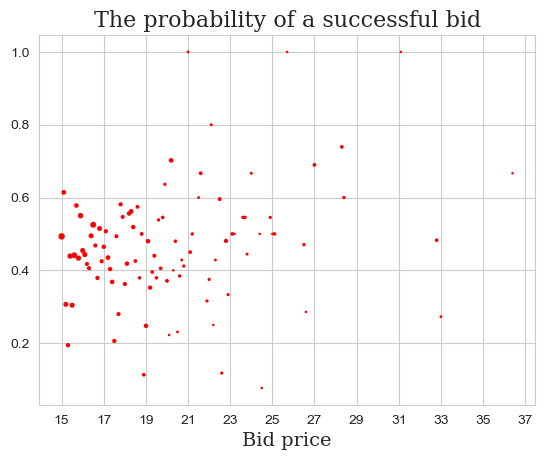

In [223]:
plt.scatter(x = df_prob.index, y= df_prob.prob, color = 'r', s = np.log(df_prob.true_count) )
plt.xticks(np.arange(15, 39, step=2))
plt.xlabel('Bid price',fontsize=14,fontfamily='serif')
plt.title("The probability of a successful bid", fontsize=16, fontfamily='serif')
plt.savefig('Bid probability before.png')

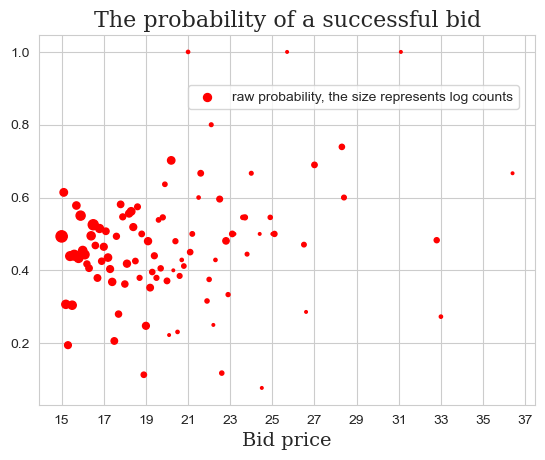

In [228]:
fig_prob, ax  = plt.subplots()
plt.title("The probability of a successful bid", fontsize=16, fontfamily='serif')
ax.scatter(x= df_prob.index, y= df_prob.prob, color = 'r' ,s = np.log(df_prob.true_count)*5)
ax.set_xlabel('Bid price',fontsize=14,fontfamily='serif')
ax.set_xticks(np.arange(15, 39, step=2))
ax.legend(['raw probability, the size represents log counts'], loc=(0.3,0.8))
plt.savefig('Bid probability before.png')


Let's see what proportion of bids actually occurs at the floor price.

In [197]:
fraction_of_all_bids = df_prob[df_prob.index == 15.0].total_count/df_prob.total_count.sum()
fraction_of_all_bids

sbpr
15.0    0.865496
Name: total_count, dtype: float64

In [198]:
fraction_of_om_bids = df_prob[df_prob.index == 15.0].true_count/df_prob.true_count.sum()
fraction_of_om_bids

sbpr
15.0    0.869065
Name: true_count, dtype: float64

Let's look at the distribution of bids at the floor price as a function of time.

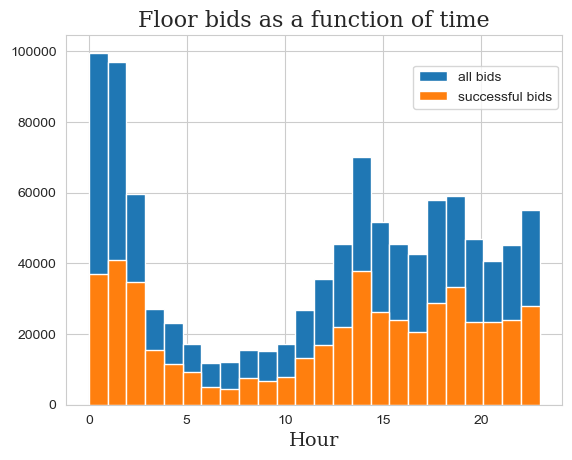

In [221]:
all_15  = df_extr0409_15_plus[(df_extr0409_15_plus.sbpr==15)].hour
om_15 = df_extr0409_15_plus[(df_extr0409_15_plus.sbpr==15) & (df_extr0409_15_plus.data==True)].hour
fig_hist, axis_hist = plt.subplots(1,1)
plt.title("Floor bids as a function of time", fontsize=16, fontfamily='serif')
axis_hist.set_xlabel('Hour',fontsize=14,fontfamily='serif')
axis_hist.hist(all_15, bins=24)
axis_hist.hist(om_15, bins=24)
axis_hist.legend(['all bids','successful bids'], loc=(0.7,0.8))
plt.savefig('Floor_time')

As noted in the introduction, the current strategy seems to place bids at the floor price at random. The purpose of this project to learn which impressions should actually be bid at the floor price. In case of success, it will have two benefits:
1. The probability of winning at the floor price, i.e. at the minimal cost will increase
2. We will be able to identify impressions at other bid prices that should actually be bid at the floor price and that will remove the noise and allow us to approximate the probability curve.

Step 5. Cleaning and reparing data for classification. </br>
<a id="part0"></a>

In [222]:
df_extr0409_15_plus.columns

Index(['id', 'minduration', 'maxduration', 'minbitrate', 'maxbitrate',
       'app_id', 'app_name', 'app_bundle', 'app_pub_id', 'genre', 'language',
       'device_make', 'device_model', 'device_os', 'device_language',
       'geo_region', 'geo_metro', 'hour', 'time', 'sbpr', 'data'],
      dtype='object')

In [230]:
#rename the dataframe
df_15_YN = df_extr0409_15_plus
df_15_YN.isnull().sum(axis = 0)

id                       0
minduration              0
maxduration              0
minbitrate               0
maxbitrate               0
app_id                   0
app_name               291
app_bundle              43
app_pub_id               0
genre              1056393
language            487233
device_make              0
device_model             0
device_os                0
device_language          0
geo_region           31681
geo_metro           205141
hour                     0
time                     0
sbpr                     0
data                     0
dtype: int64

In [231]:
df_15_YN.nunique()

id                 544228
minduration             5
maxduration            93
minbitrate              3
maxbitrate              6
app_id                411
app_name              241
app_bundle            319
app_pub_id              9
genre                1340
language               16
device_make            95
device_model          853
device_os               9
device_language         1
geo_region             80
geo_metro             230
hour                   24
time                81031
sbpr                  144
data                    2
dtype: int64

In [237]:
df_15_YN = df_15_YN.drop_duplicates(subset=['id'], keep='first')


In [238]:
len(df_15_YN[df_15_YN.data == True])

253112

In [239]:
len(df_15_YN[df_15_YN.data == False])

291116

In [240]:
df_al = pd.DataFrame(df_15_YN.groupby(['sbpr'])['sbpr'].count())
df_al.rename(columns={"sbpr":"total_count"}, inplace=True)
df_tr = pd.DataFrame(df_15_YN[df_15_YN.data==True].groupby(['sbpr'])['sbpr'].count())
df_tr.rename(columns={"sbpr":"true_count"}, inplace=True)
df_prob1 = pd.concat([df_al,df_tr], axis=1)
df_prob1["prob"] = df_prob1.apply(lambda row: row.true_count/row.total_count, axis=1)
df_prob1.head()

,total_count,true_count,prob
sbpr,,,
15.0,460407,214608.0,0.466127
15.1,481,314.0,0.652807
15.2,1747,597.0,0.341729
15.3,457,100.0,0.218818
15.4,4694,2152.0,0.458458


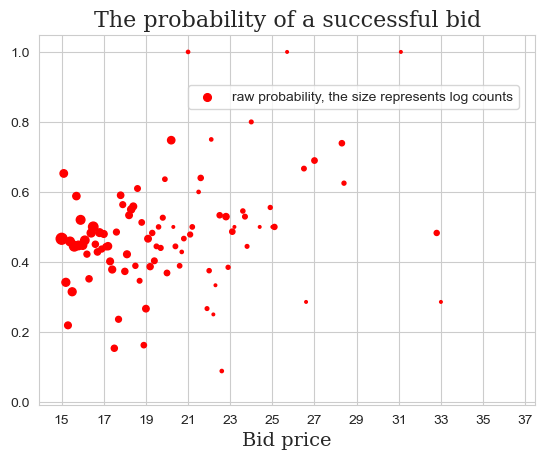

In [242]:
fig_prob1, ax  = plt.subplots()
plt.title("The probability of a successful bid", fontsize=16, fontfamily='serif')
ax.scatter(x= df_prob1.index, y= df_prob1.prob, color = 'r' ,s = np.log(df_prob1.true_count)*5)
ax.set_xlabel('Bid price',fontsize=14,fontfamily='serif')
ax.set_xticks(np.arange(15, 39, step=2))
ax.legend(['raw probability, the size represents log counts'], loc=(0.3,0.8))
#plt.savefig('Bid probability before.png')

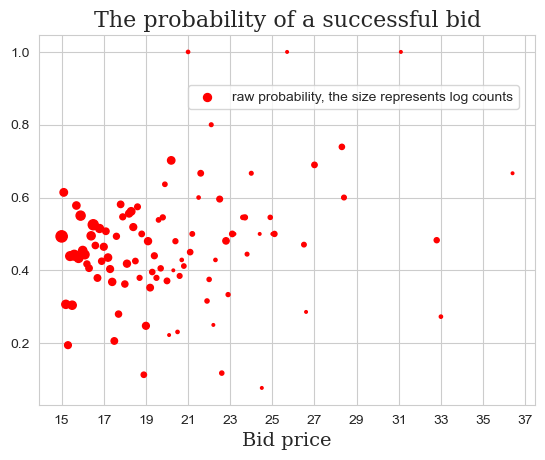

In [243]:
fig_prob